In [ ]:
!pip install pyspark

In [21]:
from pyspark.sql import SparkSession

spark = SparkSession.builder \
    .appName("AccidentVelocityPredictor") \
    .config("spark.driver.memory", "4g") \
    .getOrCreate()

print(spark)

In [22]:
from google.colab import drive
drive.mount('/drive')
df = spark.read.csv("/drive/My Drive/Cal State Fullerton/ADBMS Final Project/preprocessed_data.csv", header=True, inferSchema=True)
df.show(5)

Drive already mounted at /drive; to attempt to forcibly remount, call drive.mount("/drive", force_remount=True).
+-------+----+-------+-------+--------+-----+----+-------+-------+--------+--------+--------+-------+-------+--------+------+-------+-------+-------+------+----+-------+-------+-------+--------+--------+---+-------+--------+----+---+------+-------+-------+----+--------+--------+--------+--------+
| GENDER|YEAR|PER_TYP|INJ_SEV|DRINKING|DRUGS|MAKE|  MODEL|HIT_RUN|BODY_TYP|DEFORMED|SPEC_USE|TRAV_SP| DR_ZIP|SPEEDREL|DR_SF1|HARM_EV|WEATHER|STRATUM|REGION|  PJ|MAX_SEV|MARITAL|   RACE|DR_DRINK|CDL_STAT|AGE|NUMOCCS|MOD_YEAR|HOUR|PSU|WEIGHT|NUM_VEH|POP2018|PREV|PREV_ACC|PREV_SUS|PREV_DWI|PREV_SPD|
+-------+----+-------+-------+--------+-----+----+-------+-------+--------+--------+--------+-------+-------+--------+------+-------+-------+-------+------+----+-------+-------+-------+--------+--------+---+-------+--------+----+---+------+-------+-------+----+--------+--------+--------+---

In [23]:
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler
from pyspark.ml import Pipeline

# Step 1: Define categorical columns
categorical_cols = ["GENDER", "PER_TYP", "INJ_SEV", "DRINKING", "DRUGS", "MAKE", "MODEL",
                    "HIT_RUN", "BODY_TYP", "DEFORMED", "SPEC_USE", "SPEEDREL",
                    "DR_SF1", "HARM_EV", "WEATHER", "STRATUM", "REGION", "PJ",
                    "MAX_SEV", "MARITAL", "RACE", "DR_DRINK", "CDL_STAT"]

# Step 2: Index and Encode
indexers = [StringIndexer(inputCol=col, outputCol=col+"_indexed", handleInvalid="keep") for col in categorical_cols]
encoders = [OneHotEncoder(inputCol=col+"_indexed", outputCol=col+"_encoded") for col in categorical_cols]

# Step 3: Numerical columns
numerical_cols = ["AGE", "NUMOCCS", "MOD_YEAR", "HOUR", "PSU", "WEIGHT", "NUM_VEH",
                  "POP2018", "PREV", "PREV_ACC", "PREV_SUS", "PREV_DWI", "PREV_SPD"]

# Step 4: Assemble all input features
input_features = [col+"_encoded" for col in categorical_cols] + numerical_cols

assembler = VectorAssembler(
    inputCols=input_features,
    outputCol="features"
)

# Step 5: Build pipeline
pipeline = Pipeline(stages=indexers + encoders + [assembler])

# Step 6: Fit and Transform to create 'features'
pipeline_model = pipeline.fit(df)  # df is our cleaned DataFrame
df_prepared = pipeline_model.transform(df)

print("Encoding, assembling and features preparation completed!")


Encoding, assembling and features preparation completed!


In [24]:
# Split data into training and testing sets
train_df, test_df = df_prepared.randomSplit([0.8, 0.2], seed=123)

print(f"Training Dataset Count: {train_df.count()}")
print(f"Test Dataset Count: {test_df.count()}")


Training Dataset Count: 566424
Test Dataset Count: 141319


### Multiple Linear Regression

In [5]:
from pyspark.ml.regression import LinearRegression

# Initialize Linear Regression model
lr = LinearRegression(
    featuresCol="features",
    labelCol="TRAV_SP",
    predictionCol="prediction"
)

# Train the model
lr_model = lr.fit(train_df)

print("Model training completed!")


Model training completed!


In [6]:
lr_predictions = lr_model.transform(test_df)
# predictions.select("TRAV_SP", "prediction").show(10)

+-------+-------------------+
|TRAV_SP|         prediction|
+-------+-------------------+
|      0|  20.71689345377996|
|     25| 14.274701044325326|
|     35|  20.70991546466408|
|      3|  8.682824133568545|
|     70|  32.44080514656295|
|      0|-2.8966558147987485|
|     55| 18.848880780717764|
|      0| 24.251212812921864|
|      5| 29.891678896205036|
|     10| 16.631152025713163|
+-------+-------------------+
only showing top 10 rows



In [7]:
# 4. Evaluation
from pyspark.ml.evaluation import RegressionEvaluator
rmse = RegressionEvaluator(labelCol="TRAV_SP", predictionCol="prediction", metricName="rmse").evaluate(predictions)
r2 = RegressionEvaluator(labelCol="TRAV_SP", predictionCol="prediction", metricName="r2").evaluate(predictions)
mae = RegressionEvaluator(labelCol="TRAV_SP", predictionCol="prediction", metricName="mae").evaluate(predictions)

print(f"Root Mean Squared Error (RMSE) on test data = {rmse}")
print(f"R² (Coefficient of Determination) on test data = {r2}")
print(f"Mean Absolute Error (MAE): {mae}")

Root Mean Squared Error (RMSE) on test data = 18.157659406139903
R² (Coefficient of Determination) on test data = 0.4929491427648476


In [12]:
lr_pd = predictions.select("TRAV_SP", "prediction").toPandas()

<ipython-input-19-4fe7a0b1fa93>:16: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  binned = df.groupby('bin').agg({


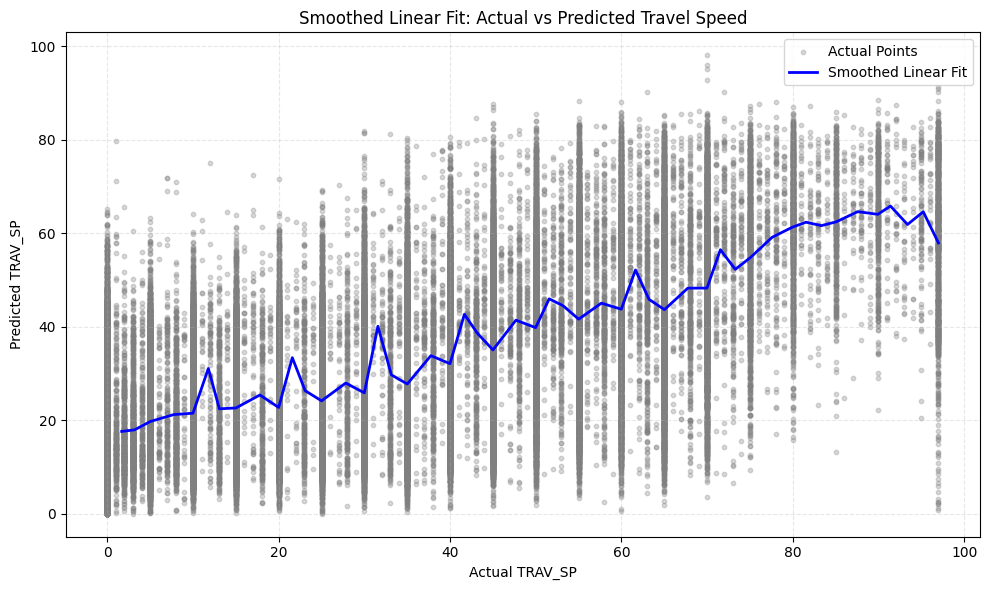

In [19]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Clean and filter
df = predictions.select("TRAV_SP", "prediction").toPandas()
df = df[(df["TRAV_SP"] >= 0) & (df["TRAV_SP"] <= 100)]
df = df[(df["prediction"] >= 0) & (df["prediction"] <= 100)]

# Step 1: Bin the data
bin_width = 2
bins = np.arange(0, 102, bin_width)
df['bin'] = pd.cut(df['TRAV_SP'], bins=bins)

# Step 2: Compute average predicted speed per bin
binned = df.groupby('bin').agg({
    'TRAV_SP': 'mean',
    'prediction': 'mean'
}).dropna()

# Step 3: Plot
plt.figure(figsize=(10, 6))

# Scatter all actual data
plt.scatter(df['TRAV_SP'], df['prediction'], color='gray', alpha=0.3, s=10, label="Actual Points")

# Line plot of smoothed predictions
plt.plot(binned['TRAV_SP'], binned['prediction'], color='blue', linewidth=2, label="Smoothed Linear Fit")

plt.xlabel("Actual TRAV_SP")
plt.ylabel("Predicted TRAV_SP")
plt.title("Smoothed Linear Fit: Actual vs Predicted Travel Speed")
plt.grid(True, linestyle="--", alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()


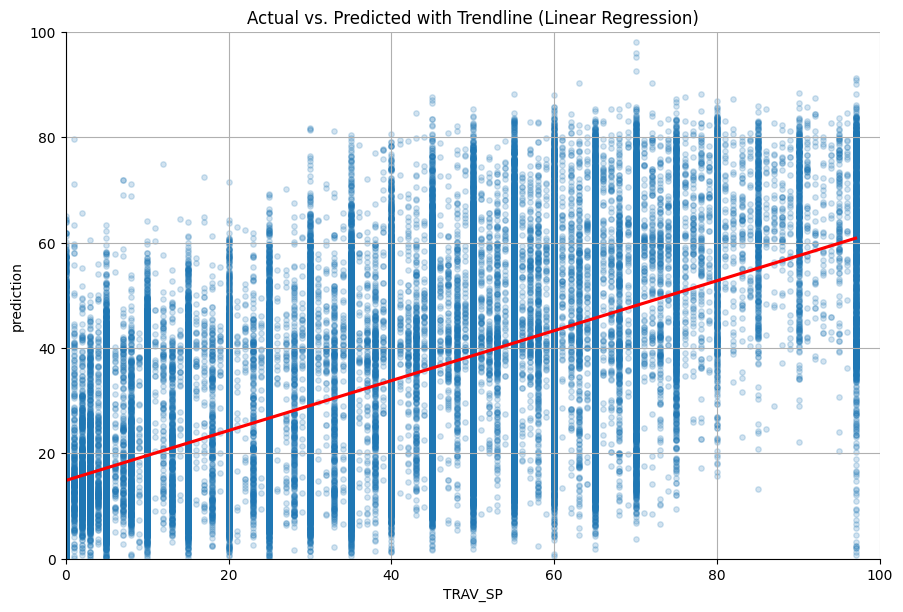

In [15]:
import seaborn as sns

sns.lmplot(
    data=lr_pd_filtered,
    x='TRAV_SP',
    y='prediction',
    height=6,
    aspect=1.5,
    scatter_kws={'alpha': 0.2, 's': 15},
    line_kws={'color': 'red'}
)
plt.title("Actual vs. Predicted with Trendline (Linear Regression)")
plt.xlim(0, 100)
plt.ylim(0, 100)
plt.grid(True)
plt.show()

### Random Forest Regression

In [ ]:
from pyspark.ml.regression import RandomForestRegressor

# Initialize Random Forest Regressor
rf = RandomForestRegressor(
    featuresCol="features",
    labelCol="TRAV_SP",
    predictionCol="prediction",
    numTrees=100,  # number of trees
    maxDepth=10    # maximum depth of each tree
)

# Train the Random Forest model
rf_model = rf.fit(train_df)

In [ ]:
# Make predictions
rf_predictions = rf_model.transform(test_df)
rf_predictions.select("TRAV_SP", "prediction").show(10)


+-------+------------------+
|TRAV_SP|        prediction|
+-------+------------------+
|      0| 6.922914629273915|
|     25| 16.92028941418132|
|     35|16.748379732820414|
|      3| 8.072771408113802|
|     70| 32.35783384225799|
|      0| 7.291657000687592|
|     55| 17.01056499901706|
|      0| 27.74128485109671|
|      5|34.757328220846304|
|     10|12.839488361044118|
+-------+------------------+
only showing top 10 rows



In [ ]:
# Evaluatuation metrics
from pyspark.ml.evaluation import RegressionEvaluator

rf_rmse = RegressionEvaluator(labelCol="TRAV_SP", predictionCol="prediction", metricName="rmse").evaluate(rf_predictions)
rf_r2 = RegressionEvaluator(labelCol="TRAV_SP", predictionCol="prediction", metricName="r2").evaluate(rf_predictions)
mae = RegressionEvaluator(labelCol="TRAV_SP", predictionCol="prediction", metricName="mae").evaluate(rf_predictions)

print(f"Random Forest RMSE on test data = {rf_rmse}")
print(f"Random Forest R² on test data = {rf_r2}")
print(f"Mean Absolute Error (MAE) on test data: {mae}")

Random Forest RMSE on test data = 17.875119522491072
Random Forest R² on test data = 0.5086061700855874
Mean Absolute Error (MAE): 14.223800069716749


In [ ]:
pipeline_model.save("/drive/My Drive/Cal State Fullerton/ADBMS Final Project/pipeline_model")



In [ ]:
rf_model.save("/drive/My Drive/Colab Notebooks/rf_model")

###  Gradient Boosted Trees

In [25]:
from pyspark.ml.regression import GBTRegressor
from pyspark.ml.evaluation import RegressionEvaluator

# Initialize GBT model
gbt = GBTRegressor(
    featuresCol="features",
    labelCol="TRAV_SP",
    predictionCol="prediction",
    maxDepth=7,
    maxIter=50
)

# Train model
gbt_model = gbt.fit(train_df)

In [26]:
# Predict on test set
gbt_predictions = gbt_model.transform(test_df)

In [27]:
# Evaluate
evaluator = RegressionEvaluator(labelCol="TRAV_SP", predictionCol="prediction")
rmse = evaluator.evaluate(gbt_predictions, {evaluator.metricName: "rmse"})
r2 = evaluator.evaluate(gbt_predictions, {evaluator.metricName: "r2"})
mae = evaluator.evaluate(gbt_predictions,{evaluator.metricName: "mae"})


print(f"GBT RMSE on test data = {rmse}")
print(f"GBT R² on test data = {r2}")
print(f"GBT Mean Absolute Error (MAE) on test data: {mae}")

GBT RMSE on test data = 17.395214652779778
GBT R² on test data = 0.5346375099038747
GBT Mean Absolute Error (MAE) on test data: 13.590331071191496


In [28]:
# Convert to Pandas
gbt_pd = gbt_predictions.select("TRAV_SP", "prediction").toPandas()

# Filter invalid values
gbt_pd = gbt_pd[(gbt_pd['TRAV_SP'] >= 0) & (gbt_pd['TRAV_SP'] <= 100)]
gbt_pd = gbt_pd[(gbt_pd['prediction'] >= 0) & (gbt_pd['prediction'] <= 100)]


<ipython-input-29-6393e62bb7af>:10: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  binned = gbt_pd.groupby('bin').agg({


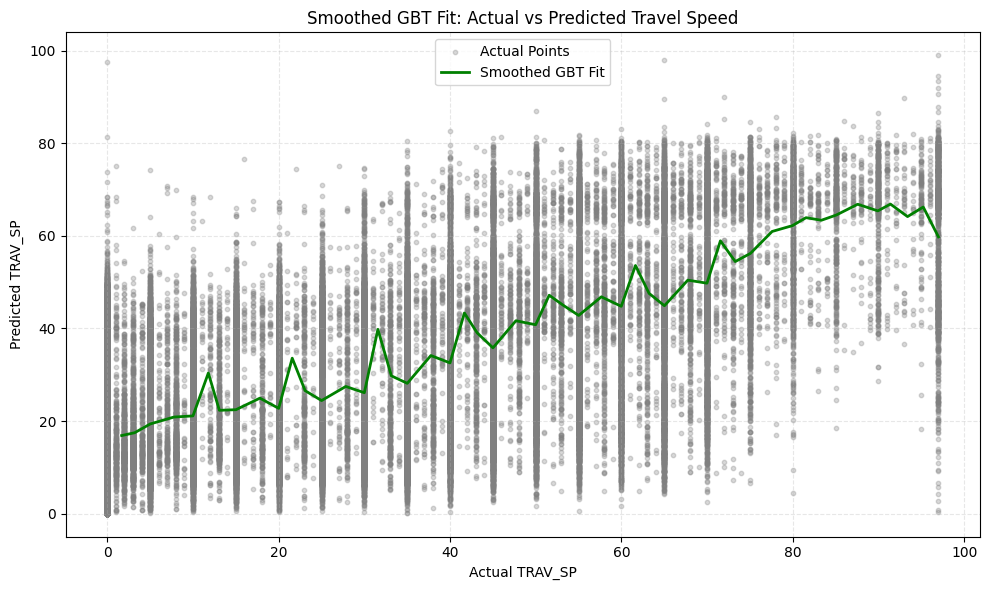

In [29]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Binning & averaging for smoothed line
bin_width = 2
bins = np.arange(0, 102, bin_width)
gbt_pd['bin'] = pd.cut(gbt_pd['TRAV_SP'], bins=bins)

binned = gbt_pd.groupby('bin').agg({
    'TRAV_SP': 'mean',
    'prediction': 'mean'
}).dropna()

# Plot
plt.figure(figsize=(10, 6))

plt.scatter(gbt_pd['TRAV_SP'], gbt_pd['prediction'], color='gray', alpha=0.3, s=10, label="Actual Points")
plt.plot(binned['TRAV_SP'], binned['prediction'], color='green', linewidth=2, label="Smoothed GBT Fit")

plt.xlabel("Actual TRAV_SP")
plt.ylabel("Predicted TRAV_SP")
plt.title("Smoothed GBT Fit: Actual vs Predicted Travel Speed")
plt.grid(True, linestyle="--", alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()
